In [1]:
import numpy as np 

import pandas as pd 

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import statsmodels.api as sm
from prophet import Prophet
from keras.layers import Dense,Dropout,LSTM
from keras.models import Sequential
from sklearn.metrics import r2_score
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

In [78]:
df = pd.read_csv('PJME_hourly.csv')

<b>Data Preprocessing</b>

In [79]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)
df.reset_index(inplace=True, drop=True)
df.rename(columns={'PJME_MW':'Demand'}, inplace=True)

In [80]:
df.drop_duplicates(subset='Datetime', keep='last', inplace=True)

In [81]:
df = df.set_index('Datetime')

In [82]:
date_range = pd.date_range(start=min(df.index), end=max(df.index), freq='H')

In [83]:
#interpolate missing values with a linear function
df = df.reindex(date_range)
df['Demand'].interpolate(method='linear', inplace=True)

In [84]:
df['dow'] = df.index.dayofweek
df['doy'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour
df['weekday'] = df.index.day_name()
df['dom'] = df.index.day
df['date'] = df.index.date 

In [85]:
df['season'] = df['month'].apply(lambda month_number: (month_number%12 + 3)//3)

<b>Data Visualisation</b>

In [87]:
df['date_and_time'] = df.index

fig = px.line(df,
              x='date_and_time',
              y='Demand',
              title=f'Power Demand (MW) over time [{min(df.year)} - {max(df.year)}]')
fig.update_traces(line=dict(width=0.05))
fig.update_layout(xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')
fig.show()

In [11]:
_ = df\
    .groupby(['hour', 'weekday'], as_index=False)\
    .agg({'Demand':'median'})

fig = px.line(_, 
              x='hour', 
              y='Demand', 
              color='weekday', 
              title='Median Hourly Power Demand per Weekday')
fig.update_layout(xaxis_title='Hour',
                  yaxis_title='Energy Demand [MW]')
fig.show()

In [12]:
_ = df\
    .groupby(['hour', 'season'], as_index=False)\
    .agg({'Demand':'median'})

fig = px.line(_,
              x='hour', 
              y='Demand', 
              color='season', 
              title='Median Hourly Power Demand per Season')
fig.update_layout(xaxis_title='Hour',
                  yaxis_title='Energy Demand [MW]')
fig.show()

1->Winter, 2->Spring, 3->Summer, 4->Autumn

<b>Forecasting Models</b>

Train/Test Split

In [13]:
CUTOFF_DATE = pd.to_datetime('2017-08-01')
TIME_DELTA = pd.DateOffset(years=8)

train = df.loc[(df.index < CUTOFF_DATE) & (df.index >= CUTOFF_DATE-TIME_DELTA) ].copy()
test = df.loc[df.index >= CUTOFF_DATE].copy()

1)Holt-Winter

In [14]:
exp_smooth_train, exp_smooth_test = train['Demand'], test['Demand']

holt_winter = sm.tsa.ExponentialSmoothing(exp_smooth_train,seasonal_periods=24*365,seasonal='add').fit()
y_hat_holt_winter = holt_winter.forecast(len(exp_smooth_test))

c:\Users\Y9GMLG726\AppData\Local\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [15]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    pe = (y_true - y_pred) / y_true
    ape = np.abs(pe)
    mape = np.mean(ape)
    return f'{mape*100:.2f}%'

In [16]:
mape_hw = mape(y_true=exp_smooth_test, y_pred=y_hat_holt_winter)
print(f'Mean Absolute Percentage Error: {mape_hw}')

Mean Absolute Percentage Error: 10.20%


In [17]:
interval = 24 * 7

x_true, y_true = exp_smooth_test.iloc[:interval].index, exp_smooth_test.iloc[:interval]
x_pred, y_pred = y_hat_holt_winter.iloc[:interval].index, y_hat_holt_winter.iloc[:interval]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_true, y=y_true,
                         mode='lines',
                         name='Test - Ground Truth'))
fig.add_trace(go.Scatter(x=x_pred, y=y_pred,
                         mode='lines', 
                         name='Test - Prediction'))

fig.update_traces(line=dict(width=0.9))
fig.update_layout(title=f'Holt-Winter Intra-Day Forecast of First {interval} Hours of Energy Demand',
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')
fig.show()

print(f'MAPE for interval of the first {interval} hours: {mape(y_true, y_pred)}')

MAPE for interval of the first 168 hours: 13.51%


2)Prophet

In [18]:
train_prophet = train[['Demand']].reset_index().rename(columns={'index':'ds', 'Demand':'y'})
test_prophet = test[['Demand']].reset_index().rename(columns={'index':'ds','Demand':'y'})

In [19]:
def is_spring(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 3) & (date.month <= 5)

def is_summer(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 6) & (date.month <= 8)

def is_autumn(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 9) & (date.month <= 11)

def is_winter(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 12) | (date.month <= 2)

def is_weekend(ds):
    date = pd.to_datetime(ds)
    return date.day_name() in ('Saturday', 'Sunday')


train_prophet['is_spring'] = train_prophet['ds'].apply(is_spring)
train_prophet['is_summer'] = train_prophet['ds'].apply(is_summer)
train_prophet['is_autumn'] = train_prophet['ds'].apply(is_autumn)
train_prophet['is_winter'] = train_prophet['ds'].apply(is_winter)
train_prophet['is_weekend'] = train_prophet['ds'].apply(is_weekend)
train_prophet['is_weekday'] = ~train_prophet['ds'].apply(is_weekend)


test_prophet['is_spring'] = test_prophet['ds'].apply(is_spring)
test_prophet['is_summer'] = test_prophet['ds'].apply(is_summer)
test_prophet['is_autumn'] = test_prophet['ds'].apply(is_autumn)
test_prophet['is_winter'] = test_prophet['ds'].apply(is_winter)
test_prophet['is_weekend'] = test_prophet['ds'].apply(is_weekend)
test_prophet['is_weekday'] = ~test_prophet['ds'].apply(is_weekend)

In [20]:
prophet = Prophet()

In [21]:
prophet.add_seasonality(name='yearly', period=365.25, fourier_order=10)
prophet.add_seasonality(name='weekly_spring', period=7,fourier_order=5, condition_name='is_spring')
prophet.add_seasonality(name='weekly_summer', period=7,fourier_order=5, condition_name='is_summer')
prophet.add_seasonality(name='weekly_autumn', period=7,fourier_order=5, condition_name='is_autumn')
prophet.add_seasonality(name='weekly_winter', period=7,fourier_order=5, condition_name='is_winter')
prophet.add_seasonality(name='daily_spring',  period=1,fourier_order=5, condition_name='is_spring')
prophet.add_seasonality(name='daily_summer',  period=1,fourier_order=5, condition_name='is_summer')
prophet.add_seasonality(name='daily_autumn',  period=1,fourier_order=5, condition_name='is_autumn')
prophet.add_seasonality(name='daily_winter',  period=1,fourier_order=5, condition_name='is_winter')
prophet.add_seasonality(name='daily_weekend',  period=1,fourier_order=5, condition_name='is_weekend')
prophet.add_seasonality(name='daily_weekday',  period=1,fourier_order=5, condition_name='is_weekday')

In [22]:
prophet.fit(train_prophet)
future = test_prophet.drop(['y'], axis=1)

16:08:04 - cmdstanpy - INFO - Chain [1] start processing
16:10:37 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
forecast = prophet.predict(future)

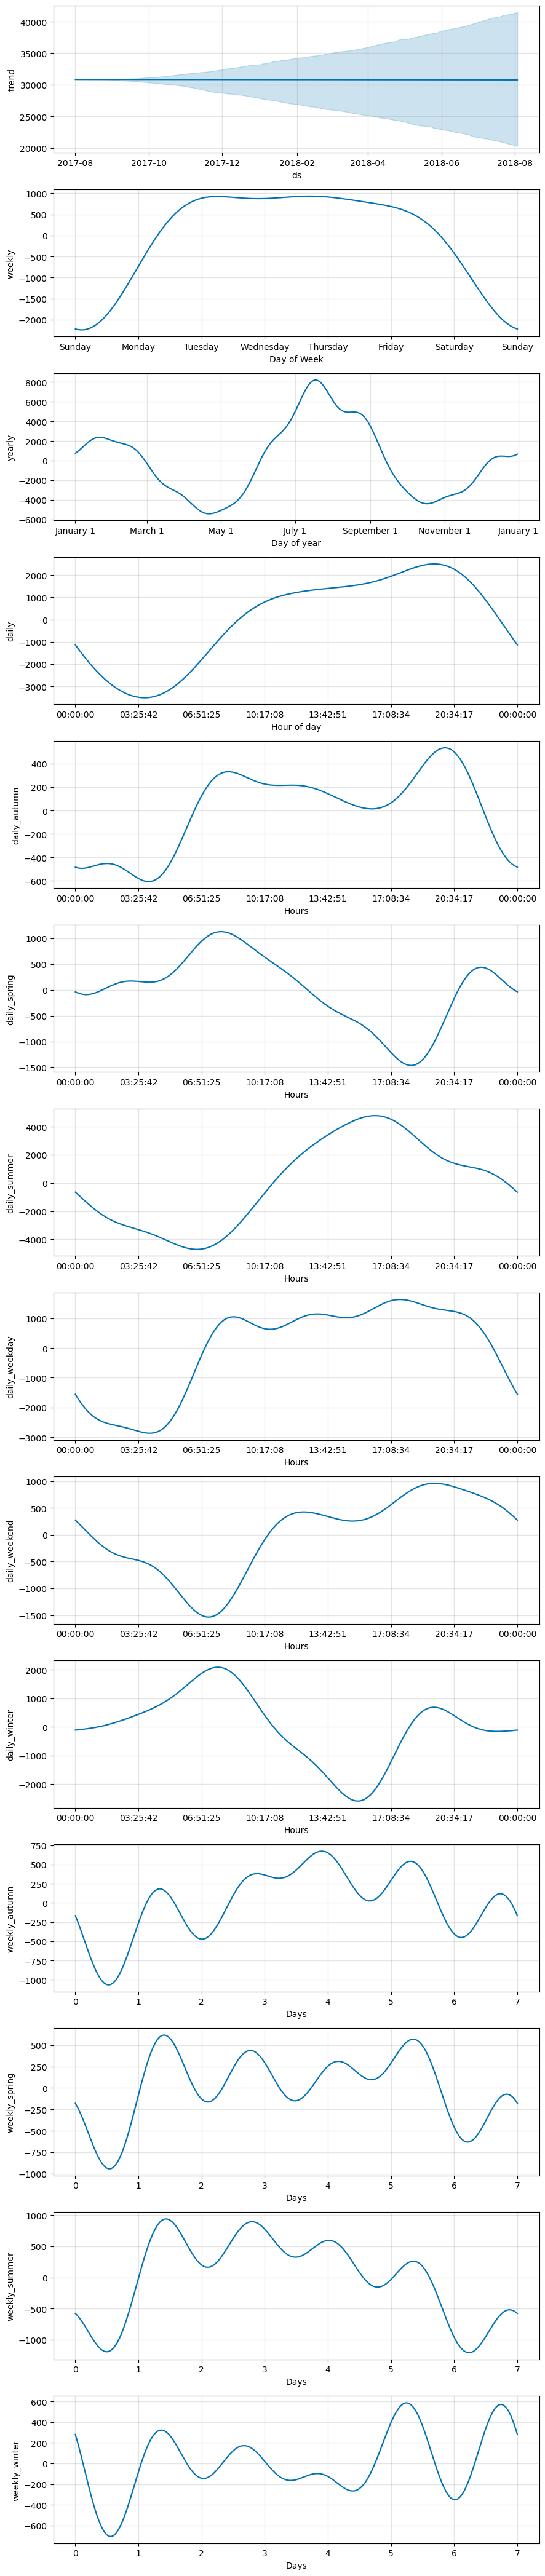

In [24]:
pd.plotting.register_matplotlib_converters()
_ = prophet.plot_components(forecast)

In [25]:
print(f'MAPE for Prophet\'s predictions: {mape(test_prophet.y, forecast.yhat)}')

MAPE for Prophet's predictions: 9.26%


In [26]:
interval = 24 * 7

x_true, y_true = test_prophet.iloc[:interval].ds, test_prophet.iloc[:interval].y
x_pred, y_pred = forecast.iloc[:interval].ds, forecast.iloc[:interval].yhat

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_true, y=y_true,
                         mode='lines',
                         name='Test - Ground Truth'))
fig.add_trace(go.Scatter(x=x_pred, y=y_pred,
                         mode='lines', 
                         name='Test - Prediction'))

fig.update_traces(line=dict(width=0.9))
fig.update_layout(title=f'Prophet Intra-Day Forecast of First {interval} Hours of Energy Demand',
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')
fig.show()

3)LSTM

In [121]:
data=df[['date_and_time','Demand']].reset_index(drop=True)
data.index=data['date_and_time']
data=data.drop(columns='date_and_time')

In [123]:
def load_data(data, seq_len):
    X_train = []
    y_train = []
    
    for i in range(seq_len, len(data)):
        X_train.append(data.iloc[i-seq_len : i, 0])
        y_train.append(data.iloc[i, 0])
    
    X_test = X_train[140000:]             
    y_test = y_train[140000:]
    
    X_train = X_train[:140000]           
    y_train = y_train[:140000]
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    X_train = np.reshape(X_train, (140000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [124]:
seq_len = 20 

X_train, y_train, X_test, y_test = load_data(data, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (140000, 20, 1)
y_train.shape =  (140000,)
X_test.shape =  (5372, 20, 1)
y_test.shape =  (5372,)


In [125]:
lstm_model = Sequential()
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer="adam",loss="MSE")

In [126]:
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
140/140 [==============================] - 57s 324ms/step - loss: 1070810112.0000
Epoch 2/10
140/140 [==============================] - 49s 352ms/step - loss: 1070317120.0000
Epoch 3/10
140/140 [==============================] - 44s 312ms/step - loss: 1069934336.0000
Epoch 4/10
140/140 [==============================] - 40s 285ms/step - loss: 1069563008.0000
Epoch 5/10
140/140 [==============================] - 41s 294ms/step - loss: 1069194368.0000
Epoch 6/10
140/140 [==============================] - 37s 263ms/step - loss: 1068829184.0000
Epoch 7/10
140/140 [==============================] - 45s 325ms/step - loss: 1068465600.0000
Epoch 8/10
140/140 [==============================] - 42s 300ms/step - loss: 1068102912.0000
Epoch 9/10
140/140 [==============================] - 38s 274ms/step - loss: 1067740992.0000
Epoch 10/10
140/140 [==============================] - 49s 354ms/step - loss: 1067379904.0000


In [127]:
lstm_predictions = lstm_model.predict(X_test)

168/168 [==============================] - 7s 19ms/step


In [128]:
lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  -25.8322390531441
